# Reconstruction test  
ACAE was trained for 100 epochs 

In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam


from absl import app

# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob

from scipy.stats import ks_2samp

Using TensorFlow backend.


## Load models

In [2]:
encoder = load_model("/home/aogorodnikov/aae/encoder.h5")
decoder = load_model("/home/aogorodnikov/aae/decoder.h5")
discriminator = load_model("/home/aogorodnikov/aae/discriminator.h5")
generator = load_model("/home/aogorodnikov/aae/generator.h5")

Instructions for updating:
Colocations handled automatically by placer.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Notes  
We need to set basic parameters for input data, like dimensions, number of filters (3 for RGB)  
Also we compile the models

In [3]:
input_dim = (104,104,3)
latent_dim=32

# compile imported models into assembled autoencoder
autoencoder_input = Input(shape=input_dim)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

## Notes  
We create a function that takes a single class (cellular phenotype) and test reconstruction loss for autoencoder and discriminator

In [7]:
def anomaly_score(cell_pheno):
    [shutil.rmtree(x) for x in glob("/home/aogorodnikov/test/*")]
    input_dir = os.path.join("/home/aogorodnikov/classes_rgb_corrected/", cell_pheno)
    shutil.copytree(input_dir, os.path.join("/home/aogorodnikov/test/", cell_pheno))
    img_wd = "/home/aogorodnikov/test"
    batch = 56
    input_dim = (104,104,3)
    data_loader = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_data = data_loader.flow_from_directory(
        img_wd,
        target_size=(input_dim[0], input_dim[0]),
        batch_size=batch,
        class_mode='input')
    
    batch_index = 0
    discriminator_batch_losses = []
    ks_batch = []
    while batch_index <= train_data.batch_index:
        data = train_data.next()
        data_list = data[0]
        data_size = len(data_list)

        fake_latent = encoder.predict(data_list)
        discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
        discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
        discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)

            
        batch_index = batch_index + 1
        discriminator_batch_losses.append(discriminator_history[0])
        ks_batch.append(ks_test)
    
    
    
    
    ae_res = autoencoder.evaluate_generator(train_data)[0]
    adv_res = np.mean(discriminator_batch_losses)
    
    print('Class: {}\nae_loss: {}\nadv_loss: {}'.format(cell_pheno, ae_res, adv_res))
    return [ae_res, adv_res]
    
        

## Notes  
We create a list of thise class directories and deploy the function above in list comprehension logic

In [8]:
dirs = [x for x in os.listdir("/home/aogorodnikov/classes_rgb_corrected/") if os.path.isdir(os.path.join("/home/aogorodnikov/classes_rgb_corrected/", x))]
results = [[x, anomaly_score(cell_pheno=x)] for x in dirs]

Found 684 images belonging to 1 classes.
24/24 [==============================] - 0s 181us/step
Class: confluent
ae_loss: 0.005207642174886855
adv_loss: 0.760744924073691
ks_pvalue: 0.4710675553633359
Found 313 images belonging to 1 classes.
66/66 [==============================] - 0s 265us/step
Class: cytokinesis
ae_loss: 0.005978981418291124
adv_loss: 0.76058169408106
ks_pvalue: 0.47733833891709937
Found 1124 images belonging to 1 classes.
8/8 [==============================] - 0s 362us/step
Class: negative
ae_loss: 0.0047015743131262125
adv_loss: 0.6730009751255009
ks_pvalue: 0.48775880501623486
Found 310 images belonging to 1 classes.
60/60 [==============================] - 0s 256us/step
Class: nuclear_mess
ae_loss: 0.006099429921877961
adv_loss: 0.7721628675385128
ks_pvalue: 0.5577918789678155
Found 857 images belonging to 1 classes.
34/34 [==============================] - 0s 337us/step
Class: large_nuclei
ae_loss: 0.005084151508071424
adv_loss: 0.8018852497975366
ks_pvalue: 0.5

## Notes  
Printed results show adversarial and autoencoder losses fpr each class

In [8]:
results

[['confluent', [0.0052395304120336356, 0.8320614597299596]],
 ['cytokinesis', [0.005937064578310369, 0.7239362725619802]],
 ['negative', [0.004699674862506551, 0.6887673135517406]],
 ['nuclear_mess', [0.006209361997823562, 0.7224980177387358]],
 ['large_nuclei', [0.005099604314882112, 0.79055662916488]],
 ['other', [0.0040518020776065, 0.779564362338611]],
 ['micronuclei', [0.00551873598216549, 0.733570560453553]],
 ['spindle', [0.004600882017034657, 0.6948887342050261]],
 ['Y', [0.005324033992082784, 0.741863888331822]],
 ['binucleated', [0.004913649405352771, 0.8024204703313964]],
 ['polarity', [0.0051511010155081745, 0.7308858743735722]],
 ['croissant', [0.004723330433733804, 0.727723164423346]]]

# Conclusions  
1. *Negative* class has the smallest autoencoder and second smallest adversarial loss.  

In [29]:
img_wd = "/home/aogorodnikov/classes_rgb_corrected/"
batch = 56
input_dim = (104,104,3)
latent_dim=32
epoch = 10
conv=True
adversarial=True


In [30]:
# LOAD DATA
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 7557 images belonging to 12 classes.


In [31]:
data = train_data.next()
data_list = data[0]
fake_latent = encoder.predict(data_list)

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [32]:
a = fake_latent[0]
b = np.random.randn(latent_dim) * 5.

In [42]:
ks_2samp(a,b).statistic

0.15625

In [14]:
def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

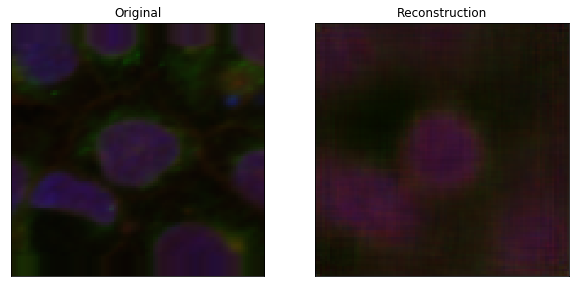

In [15]:
choice = np.random.choice(np.arange(32))
original = data_list[choice]

original_1 = np.expand_dims(original, axis=0)

latent = encoder.predict(original_1)

reconstruction = decoder.predict(latent)

draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction[0]}])



In [16]:
autoencoder.evaluate_generator(train_data)

[0.004902165813330377, 0.5780405813192934]

In [149]:
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')



Found 7557 images belonging to 12 classes.


In [168]:
fake_latent = encoder.predict(data_list)

fake_latent

array([[-4.564788  ,  0.9550102 ,  8.51572   , ..., -0.4226413 ,
        -2.8371184 ,  7.1186886 ],
       [-2.9885685 , -5.655708  ,  3.7550688 , ...,  6.76246   ,
         2.7704573 , -9.528672  ],
       [-1.4381589 , -1.331906  ,  1.8464564 , ..., -4.284677  ,
        -0.1258904 ,  5.611074  ],
       ...,
       [-3.8753633 , -8.207726  , 13.1112995 , ...,  1.2015983 ,
         1.0967643 , -0.73942983],
       [-4.6393876 , -1.6131024 ,  3.0874438 , ...,  1.7831937 ,
         3.7470875 ,  2.2027905 ],
       [-4.1928124 , -7.6067743 ,  1.2030356 , ...,  1.3560551 ,
        13.47506   , -9.464908  ]], dtype=float32)

In [172]:
fake_latent.shape

(56, 32)

In [169]:
discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)